In [1]:
!pip install tsai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TCN IMPLEMENTATION

# Bai, S., Kolter, J. Z., & Koltun, V. (2018). An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271.
# Official TCN PyTorch implementation: https://github.com/locuslab/TCN

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [3]:
import torch.nn.functional as F
from torch import nn

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

In [4]:
class VolForecastSingleHorizon(nn.Module):
    def __init__(self, input_dim, horizon):
        super(VolForecastSingleHorizon, self).__init__()
        self.input_dim = input_dim
        self.horizon = horizon

        self.tcn = TCN(input_size=input_dim, output_size=1, num_channels=8*[25], kernel_size=7, dropout=0.1)
    
    def forward(self, x):
        return self.tcn(x)

# class VolForecastMultipleHorizons(nn.Module):
#     def __init__(self, input_dim, horizon):
#         super(VolForecastMultipleHorizons, self).__init__()
#         self.input_dim = input_dim
#         self.horizon = horizon

#         self.tcn = TCN(input_size=input_dim, output_size=horizon, num_channels=[300, 250, 200, 200, 150, 100], kernel_size=7, dropout=0.1)
    
#     def forward(self, x):
#         return self.tcn(x)

In [5]:
import math

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def get_data_single_horizon(file_name, input_dim, horizon, val_ratio=0.01):
    # Get data from csv
    df = pd.read_csv(file_name)
    inputs = df_to_tensor(df[['vol']])
    outputs = df_to_tensor(df[['vol']])
    
    # Group input_dim concecutive input points together, and horizon concecutive output vectors together
    inputs = torch.stack([inputs[i:i - input_dim - horizon] for i in range(input_dim)], dim = 1)
    outputs = outputs[input_dim + horizon:]

    assert len(inputs) == len(outputs), f"Input and output arrays have different lengths: {len(inputs)} \= {len(outputs)}"
    
    # Do train/validation split
    val_len = math.ceil(val_ratio * len(inputs))
    train_x = inputs[:-val_len]
    train_y = outputs[:-val_len]
    val_x = inputs[-val_len:]
    val_y = outputs[-val_len:]

    print("Train input dimension:", train_x.shape)
    print("Train output dimension:", train_y.shape)
    print("Validation input dimension:", val_x.shape)
    print("Validation output dimension:", val_y.shape)

    return train_x, train_y, val_x, val_y

# def get_data_multiple_horizons(file_name, input_dim, horizon, val_ratio=0.01):
#     # Get data from csv
#     df = pd.read_csv(file_name)
#     inputs = df_to_tensor(df[['vol']])
#     outputs = df_to_tensor(df[['vol']])
    
#     # Group input_dim concecutive input points together, and horizon concecutive output vectors together
#     inputs = torch.stack([inputs[i:i - input_dim - horizon] for i in range(input_dim)], dim = 1)
#     outputs = torch.stack([outputs[input_dim + i:i - horizon] for i in range(horizon)], dim = 1).squeeze()

#     assert len(inputs) == len(outputs), f"Input and output arrays have different lengths: {len(inputs)} \= {len(outputs)}"
    
#     # Do train/validation split
#     val_len = math.ceil(val_ratio * len(inputs))
#     train_x = inputs[:-val_len]
#     train_y = outputs[:-val_len]
#     val_x = inputs[-val_len:]
#     val_y = outputs[-val_len:]

#     print("Train input dimension:", train_x.shape)
#     print("Train output dimension:", train_y.shape)
#     print("Validation input dimension:", val_x.shape)
#     print("Validation output dimension:", val_y.shape)

#     return train_x, train_y, val_x, val_y

In [6]:
from pandas.core.dtypes.cast import validate_numeric_casting
import torch.optim as optim

def train(model, opts, train_x, train_y, val_x, val_y):
    loss_fn = nn.MSELoss()
    input_dim = model.input_dim
    batch_size = opts['batch_size']
    validation_period = opts['validation_period']

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(opts['nepochs']):
        # Sample batch input randomly
        random_ids = np.random.randint(len(train_x), size=batch_size)
        train_input = train_x[random_ids]
        train_output = train_y[random_ids]        

        optimizer.zero_grad()
        loss = loss_fn(model(train_input), train_output)
        loss.backward()
        optimizer.step()

        if (epoch+1) % validation_period == 0:
            train_losses += [loss]

            val_loss = loss_fn(model(val_x), val_y)
            val_losses += [val_loss]
  
            print(f"Epoch: {epoch}, training loss: {loss}, validation loss: {val_loss}")
    
    return train_losses, val_losses

In [7]:
input_dim=300
horizon=50
model=VolForecastSingleHorizon(input_dim=input_dim, horizon=horizon)
train_x, train_y, val_x, val_y = get_data_single_horizon('5sec_intervals_no_na_normed.csv', input_dim=input_dim, horizon=horizon)

Train input dimension: torch.Size([571369, 300, 1])
Train output dimension: torch.Size([571369, 1])
Validation input dimension: torch.Size([5772, 300, 1])
Validation output dimension: torch.Size([5772, 1])


In [8]:
opts = {
    "nepochs": 500,
    "batch_size": 128,
    "validation_period": 50
}
train_losses, val_losses = train(model, opts, train_x, train_y, val_x, val_y)

Epoch: 0, training loss: 6.89976692199707, validation loss: 9.23324203491211
Epoch: 50, training loss: 0.6705580949783325, validation loss: 0.11639296263456345
Epoch: 100, training loss: 0.6796498894691467, validation loss: 0.08853588998317719
Epoch: 150, training loss: 0.24098455905914307, validation loss: 0.16826435923576355
Epoch: 200, training loss: 0.06302161514759064, validation loss: 0.09835638105869293
Epoch: 250, training loss: 0.05724390596151352, validation loss: 0.1300203800201416
Epoch: 300, training loss: 0.41988930106163025, validation loss: 0.09525930881500244
Epoch: 350, training loss: 0.0909641906619072, validation loss: 0.08277499675750732
Epoch: 400, training loss: 0.2852536737918854, validation loss: 0.07174279540777206
Epoch: 450, training loss: 0.07680054008960724, validation loss: 0.0742703303694725


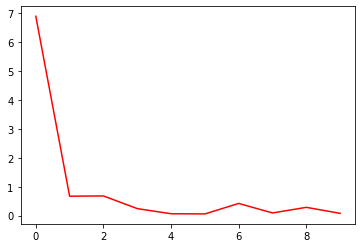

In [9]:
# Graphing losses
plt.plot(np.array([x.detach().numpy() for x in train_losses]), 'r')

In [15]:
def plot_model_performance_single_horizon(model, x, y, num_samples, horizon):
  assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
  pred = model(x[:num_samples])
  reality = y[horizon:num_samples+horizon]

  plt.plot(pred.detach().numpy(), 'r')
  plt.plot(reality.detach().numpy(), 'b')

# def plot_model_performance_multiple_horizons(model, x, y, num_samples, horizon):
#   assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
#   pred = model(x[:num_samples])[:, horizon-1]
#   reality = y[:num_samples][:, horizon-1]

#   plt.plot(pred.detach().numpy(), 'r')
#   plt.plot(reality.detach().numpy(), 'b')

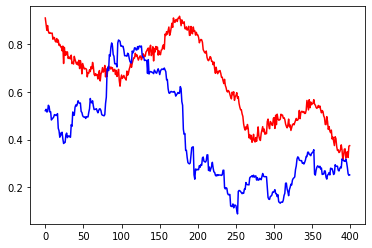

In [16]:
# MODEL PERFORMANCE - TEST PART
plot_model_performance_single_horizon(model, train_x, train_y, num_samples=400, horizon=20)

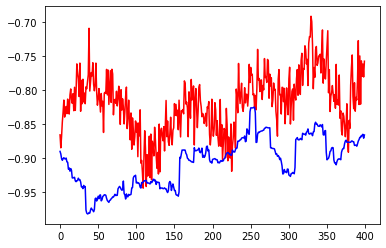

In [18]:
# MODEL'S PERFORMANCE - VALIDATION PART
plot_model_performance_single_horizon(model, val_x, val_y, num_samples=400, horizon=20)